<a href="https://colab.research.google.com/github/schokoro/AttentionNMT/blob/dev/en_jap_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Первым делом проверим какая карточка нам досталась. Лучшим вариантом будет `Tesla P100-PCIE-16GB`, на остальных будет считаться медленнее.

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    raise RuntimeErrorx
else:
    print(torch.cuda.get_device_name(0))

Tesla T4


In [2]:
!pip install janome pandarallel  > /dev/null

In [3]:
!rm -rf AttentionNMT/
!git clone -b dev https://github.com/schokoro/AttentionNMT.git > /dev/null
# !pip install allennlp wget youtokentome ipymarkup seqeval livelossplot> /dev/null

Cloning into 'AttentionNMT'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 35 (delta 16), reused 18 (delta 8), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [4]:
import sys
sys.path.append('/content/AttentionNMT')

In [5]:
%load_ext autoreload
%autoreload 2
import AttentionNMT
from AttentionNMT.transformer import Transformer, Encoder, Decoder
from AttentionNMT.utils import count_parameters, initialize_weights, translate_sentence, evaluate_blue, train, evaluate, display_attention, sentence_blue

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
%autoreload 2
from typing import Dict, List, Optional
import torch.nn as nn

from matplotlib.font_manager import FontProperties
from torchtext.data import Field, BucketIterator
from tqdm.notebook import tqdm
from pandarallel import pandarallel
import torchtext
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import spacy
import warnings
import re
import random
import math
import time
from janome.tokenizer import Tokenizer as JTokenizer
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
tqdm.pandas()
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=False)

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Подготовка данных и EDA

Для обучения англо-японского переводчика будем использовать [Tanaka Corpus](http://www.edrdg.org/wiki/index.php/Tanaka_Corpus). Прямая ссылка на скачивание [здесь](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz).


In [8]:
!wget -q ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz 
!gunzip -f examples.utf.gz

## Подготовка корпуса

Посмотрим, как выглядит корпус:

In [9]:
!head -4 examples.utf

A: ムーリエルは２０歳になりました。	Muiriel is 20 now.#ID=1282_4707
B: は 二十歳(はたち){２０歳} になる[01]{になりました}
A: すぐに戻ります。	I will be back soon.#ID=1284_4709
B: 直ぐに{すぐに} 戻る{戻ります}


Нам нужны только строки с префиксом `A:`
Для токенизации английского языка будем использовать spacy, для японского - токенизатор janome. Для англо-японского перевода будет лучше, если японский текст мы развернём задом наперёд. Просто поверьте. Или можете проверить. Соответственно, при переводе нам будет необходимо развернуть переведённый текст обратно.

In [10]:
nlp = spacy.load("en_core_web_sm")
jt = JTokenizer()
en_remove = re.compile(r'#ID=.+')
is_token = re.compile(r'\w+')


def get_pair(line: str) -> Dict[str, str]:
    """
    Принимает на вход строку из файла паралелльного корпуса, возвращает словарь
     с японским и английским предложениями
    """
    jap, en = line.strip().split('\t')
    jap = jap.replace('A: ', '').strip()
    en = en_remove.sub('', en)
    return {'en': en, 'jap': jap}
  
def src_tokenize(text: str) -> List[str]:
    """
    Токенизирует английский текст, возвращает список токенов.
    """
    return [tok.text for tok in nlp.tokenizer(text)]


def trg_tokenize(text: str) -> List[str]:
    """
    Токенизирует японский текст, возвращает список токенов в обратном порядке
    """
    return [token.base_form for token in jt.tokenize(text)][: : -1]  # if is_token.match(token.base_form)


dicts = []
with open('examples.utf', 'r') as fobj:
    for i, line in enumerate(fobj):
        if line.startswith('A:'):
            dicts.append(get_pair(line))



corpus_df = pd.DataFrame(dicts)   

Посчитаем длины предложений в символах и посмотрим их корреляцию.

In [11]:
corpus_df['en_len'] = corpus_df['en'].map(lambda x: len(x))
corpus_df['jap_len'] = corpus_df['jap'].map(lambda x: len(x))

In [12]:
corpus_df[['en_len','jap_len' ]].corr()

,en_len,jap_len
en_len,1.000000,0.809457
jap_len,0.809457,1.000000


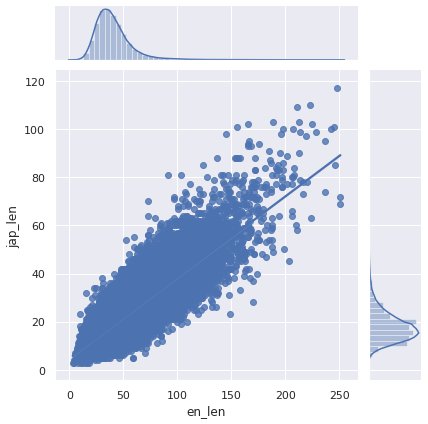

In [13]:
sns.jointplot("en_len", "jap_len", data=corpus_df, kind="reg");

А теперь - длины предложений в токенах и их корреляцию.

In [14]:
%time corpus_df['en_tok_len'] = corpus_df['en'].parallel_apply(lambda x: len(src_tokenize(x)))

CPU times: user 40.1 ms, sys: 82.2 ms, total: 122 ms
Wall time: 4.58 s


In [15]:
%time corpus_df['jap_tok_len'] = corpus_df['jap'].parallel_apply(lambda x: len(trg_tokenize(x)))

CPU times: user 106 ms, sys: 94.9 ms, total: 201 ms
Wall time: 2min 5s


In [16]:
corpus_df[['en_tok_len','jap_tok_len' ]].corr()

,en_tok_len,jap_tok_len
en_tok_len,1.000000,0.775549
jap_tok_len,0.775549,1.000000


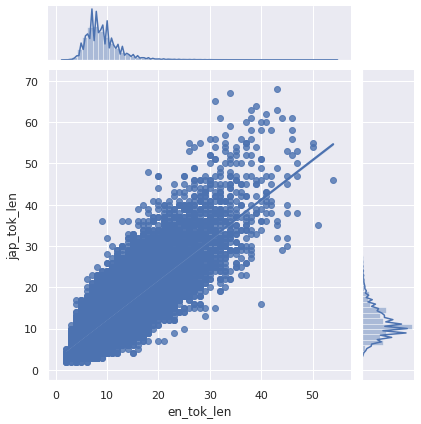

In [17]:
sns.jointplot("en_tok_len", "jap_tok_len", data=corpus_df, kind="reg")

In [18]:
corpus_df.describe()

,en_len,jap_len,en_tok_len,jap_tok_len
count,149791.000000,149791.000000,149791.000000,149791.000000
mean,40.471270,18.378407,9.307989,11.744270
std,17.417855,7.237879,3.594693,4.449102
min,3.000000,3.000000,2.000000,2.000000
25%,29.000000,14.000000,7.000000,9.000000
50%,37.000000,17.000000,9.000000,11.000000
75%,47.000000,21.000000,11.000000,14.000000
max,251.000000,117.000000,54.000000,68.000000


Выбросим из корпуса предложения длиннее чем `quantile(0.9)` и сохраним в файл.

In [19]:
corpus_df.en_tok_len.quantile(0.9), corpus_df.jap_tok_len.quantile(0.9)

(13.0, 17.0)

In [20]:
new_corpus_df = corpus_df[
    (corpus_df.en_tok_len < corpus_df.en_tok_len.quantile(0.9)) &
    (corpus_df.jap_tok_len < corpus_df.jap_tok_len.quantile(0.9)) 
]
corpus_df.shape

(149791, 6)

In [21]:
new_corpus_df.to_csv('en_jap_corpus.csv', index=None, columns=['en', 'jap'])

In [22]:
max_src = corpus_df.en_tok_len.max() + 2
max_trg = corpus_df.jap_tok_len.max() + 2

In [23]:
SRC = Field(
            tokenize = src_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(
            tokenize = trg_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [24]:
%%time
trn_data_fields = [("src", SRC), ("trg", TRG)]

dataset = torchtext.data.TabularDataset(
    path='en_jap_corpus.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)



CPU times: user 2min 2s, sys: 369 ms, total: 2min 3s
Wall time: 2min 3s


In [25]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [26]:
SRC.build_vocab(train_data.src, min_freq=3)  # 
print(SRC.vocab.freqs.most_common(10))

TRG.build_vocab(train_data.trg, min_freq=3)
print(TRG.vocab.freqs.most_common(10))


print(f'SRC.vocab: {len(SRC.vocab)}, TRG.vocab: {len(TRG.vocab)}')

[('.', 110945), ('the', 47508), ('to', 26425), ('i', 25461), ('a', 21923), ('is', 20993), ('he', 19826), ('you', 15670), ('of', 14218), ('in', 13554)]
[('。', 121263), ('は', 93010), ('た', 51259), ('の', 48574), ('に', 48356), ('を', 47677), ('て', 34193), ('が', 30261), ('する', 27333), ('だ', 25724)]
SRC.vocab: 9050, TRG.vocab: 11167


In [27]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    shuffle=True,
    device=device)

## Training the Transformer Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2 * HID_DIM
DEC_PF_DIM = 2 * HID_DIM
ENC_DROPOUT = 0.07
DEC_DROPOUT = 0.07

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              dropout=ENC_DROPOUT, 
              device=device,
              max_length=max_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM,
              dropout=DEC_DROPOUT, 
              device=device,
              max_length=max_trg)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
try:
    del model
    torch.cuda.empty_cache()
except:
    print('no model')

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model = Transformer()

no model


We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [30]:


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,035,935 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

We then define a small function that we can use to tell us how long an epoch takes.

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
model.apply(initialize_weights);
best_macro_bleu = 0
test_loss = np.inf

In [33]:
BEST_MODEL = 'best_blue_en_jap.pt'

In [34]:
# cross_entropy = CrossEntropyLoss(ignore_index = TRG_PAD_IDX, smooth_eps=0.03)
cross_entropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
LEARNING_RATE = 1.25e-3
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

def criterion(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return cross_entropy(pred_flat, target_flat)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.2,
                                                       verbose=True,
                                                       cooldown=0, 
                                                       patience=4,              
                                                       threshold=0.01,
                                                       min_lr=5e-5)

In [35]:
# train(model, train_iterator, optimizer, criterion, CLIP, 128)
train_history = []
valid_history = []
blue_history = []

In [36]:
N_EPOCHS = 5
CLIP = 1

try:
    best_valid_loss = evaluate(model, valid_iterator, criterion)
except:
    best_valid_loss = float('inf')
print(f'Loss: {best_valid_loss:7.3f}')


for epoc_num, epoch in tqdm(enumerate(range(N_EPOCHS)), total=N_EPOCHS):
    curent_lr = optimizer.param_groups[0]['lr']
    start_time = time.time()
    try:
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 1, 1)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        scheduler.step(valid_loss)
                
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print('Новая лучшая модель')

        macro_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize)
        if macro_bleu > best_macro_bleu:
            best_macro_bleu = macro_bleu
            print('Новый лучший blue')            
            torch.save(model.state_dict(), BEST_MODEL)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        blue_history.append(macro_bleu)

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        
        print(f'\tMacro-average BLEU: {macro_bleu:.6f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print('_' * 100)
    except KeyboardInterrupt:
        print(f"Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]['lr']}")
        break
    finally:
        pass

Loss:   9.344


Новая лучшая модель


TypeError: ignored

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

First, we'll get an example from the training set.

In [ ]:
!wget -q https://github.com/vuthaihoc/fonts/raw/master/JUSTRAJDEEP/Osaka.ttf

fontprop_x = FontProperties(size=20)
fontprop_y = FontProperties(fname='Osaka.ttf', size=20)

In [ ]:
# def display_attention(sentence:List[str], translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2):
    
#     assert n_rows * n_cols == n_heads

#     translation = translation[::-1]
#     attention = torch.flip(attention, (2,))
    
#     fig = plt.figure(figsize=((n_cols + 1.5) * 6,(n_rows + 1) * 6))
    
#     for i in range(n_heads):
        
#         ax = fig.add_subplot(n_rows, n_cols, i+1)
        
#         _attention = attention.squeeze(0)[i].cpu().detach().numpy()

#         cax = ax.matshow(_attention, cmap='bone')

#         ax.tick_params(labelsize=20)
#         ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],  #
#                            rotation=45, fontproperties=fontprop_x)
#         ax.set_yticklabels(['']+translation, fontproperties=fontprop_y)

#         ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#         ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()
#     plt.close()

# def sentence_blue(original: List[str], translation: List[str], n_grams=3) -> float:
#     blue = nltk.translate.bleu_score.sentence_bleu(
#         original,
#         translation[: -1],
#         weights = [1/n_grams] * n_grams
#         ) 
#     return blue

In [ ]:
example_idx = random.randint(0, len(train_data) - 1)

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y)

In [ ]:
attention.shape

In [ ]:
example_idx = random.randint(0, len(valid_data) - 1)

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention)

In [ ]:
example_idx = random.randint(0, len(test_data) - 1)

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg[::-1])}')
print(f'predicted: {" ".join(translation[::-1])}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention)

In [ ]:
idxs = list(range(len(test_data)))
random.shuffle(idxs)

count = 0

for example_idx in idxs:
    example_idx = random.randint(0, 1219)
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device)
    result = [translation[0]]
    
    blue = sentence_blue(trg, translation, 4)
    if blue < .85:
        continue


    for token in translation:
        if token != result[-1]:
            result.append(token)
    print(f'src      : {" ".join(src)}')
    print(f'trg      : {" ".join(trg[::-1])}')
    print(f'predicted: {" ".join(translation[::-1])}')
    print(f'     blue: {100 * blue:.2f}%')
    display_attention(src, translation, attention)

    count += 1
    if count > 40:
        break